- 1) [x] Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

- a) Для отображения картинки воспользуйтесь вспомогательной функцией:

In [1]:
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
import skimage
from PIL import Image

import pandas as pd
import numpy as np

In [2]:
def draw_picture(image, title, bgr=False):
    plt.figure(figsize=(7, 5))
    plt.imshow(image)
    plt.title(title)
    plt.show()

def rgb_split(image):
    b, g, r = cv2.split(image)
    return cv2.merge([r, g, b])
    
def shape2d(old_array, array):
    return array.reshape((old_array.shape[0] * old_array.shape[1], 3))

def reshape(old_array, array):
    return array.reshape((old_array.shape[0], old_array.shape[1], 3))

def ssim_scorer(old_image, model_result):
    return round(ssim(old_image, model_result, channel_axis=2), 2)

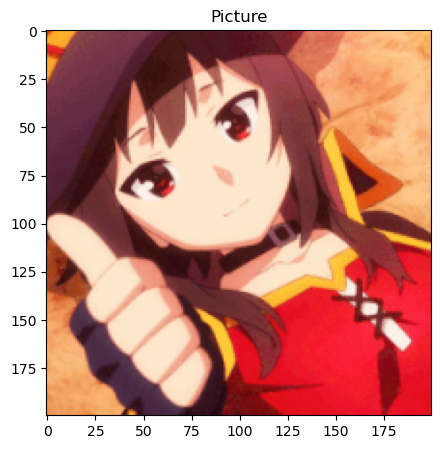

In [22]:
# accessing image
bgr_img = cv2.imread('Data/pic.png')
# bgr_img = cv2.resize(bgr_img, (128, 128))
# reshaping into correct rgb pixels array
rgb_image = rgb_split(bgr_img)

# drawing a pic
draw_picture(rgb_image, 'Picture')

# converting image to 2D-array [n_pixels, [R, G, B]]
array2d = shape2d(bgr_img, rgb_image)

- 2) [x] Реализуйте три модели кластеризации:

In [23]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

- a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [24]:
def KMeans_model(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters,
                        random_state=3,
                        n_init=10
                       ).fit(array2d)

    kcenters = [[int(n) for n in i] for i in kmeans.cluster_centers_]

    yhat = kmeans.predict(array2d)
    l = [kcenters[i] for i in yhat]

    clust_img = reshape(rgb_image, np.array(l)).astype(np.uint8)
    return clust_img

- b) DBSCAN

In [25]:
db_model = DBSCAN(eps=0.001,
                  metric='euclidean', 
                  metric_params=None, 
                  algorithm='auto', 
                  p=None,
                 n_jobs=10)

yhat = db_model.fit_predict(array2d)

In [26]:
df = pd.DataFrame(array2d)
df['cluster'] = yhat
db_array = []

outer = np.array([int(i) for i in df.loc[df['cluster'] == -1].mean()][:-1])

for i in range(len(yhat)):
    db_array.append(outer) if yhat[i] == -1 else ''
    
for ind, val in zip(db_model.core_sample_indices_, db_model.components_):
    db_array.insert(ind, val)
    
db_array = np.array(db_array).astype(np.uint8)

- c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [27]:
from sklearn.neighbors import NearestCentroid

In [28]:
def Aggclust_model(n_clusters):
    yhat = AgglomerativeClustering(n_clusters=n_clusters,
                       ).fit_predict(array2d)
    
    nc = NearestCentroid()
    nc.fit(array2d, yhat)
    
    kcenters = [[int(n) for n in i] for i in nc.centroids_]

    l = [kcenters[i] for i in yhat]

    clust_img = reshape(rgb_image, np.array(l)).astype(np.uint8)
    return clust_img

In [29]:
array2d.shape

(40000, 3)


- 3) [x] Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.

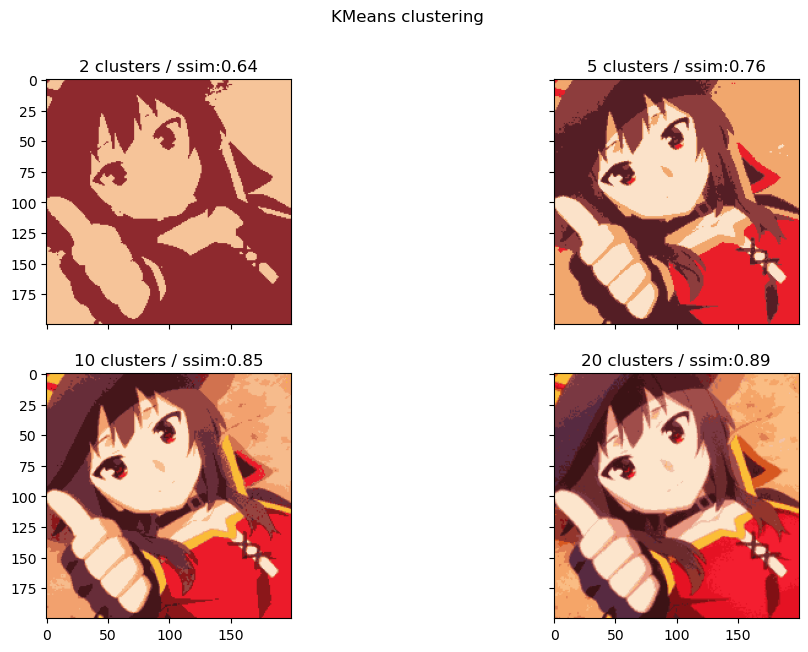

<Figure size 1000x500 with 0 Axes>

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,7))
fig.suptitle('KMeans clustering')

fig = plt.figure(figsize=(10,5))

for ax, n in zip((ax1, ax2, ax3, ax4), [2, 5, 10, 20]):
    model = KMeans_model(n)
    ax.imshow(model)
    ax.set_title(f'{n} clusters / ssim:{ssim_scorer(rgb_image, model)}')

plt.show()

<center>DBSCCAN - "Что-то пошло не так!"</center>

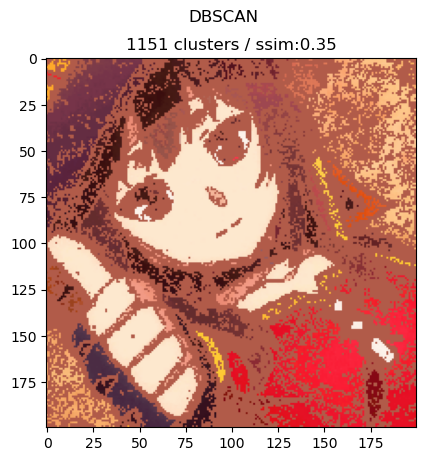

In [31]:
db_pick = reshape(rgb_image, db_array)
plt.imshow(db_pick)
plt.title(f'{len(set(yhat))} clusters / ssim:{ssim_scorer(rgb_image, db_pick)}')
plt.suptitle('DBSCAN')
plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,7))
fig.suptitle('Agglomerative clustering')

fig = plt.figure(figsize=(10,5))

for ax, n in zip((ax1, ax2, ax3, ax4), [2, 5, 10, 20]):
    model = Aggclust_model(n)
    ax.imshow(model)
    ax.set_title(f'{n} clusters / ssim:{ssim_scorer(rgb_image, model)}')

plt.show()

- 4) [x] Сформулируйте выводы по проделанной работе.

a) Какая модель показала лучший результат?

- 1) В данной задаче лучшую метрику показала KMeans. Худшую - DBSCAN.
- 2) Картинка у кластеризаторов вышла лучше качества, чем даже оригинал :)
- 3) Задача очень интересная, спасибо. Сначала разозлися, потому что обработки изображений ни разу не касался. Пришлось посидеть и почитать стороннюю документацию, переписать код много раз, но в итоге поймал себя на мысли, что это очень интересно, в голову даже пришли идеи для пары проектов. Такие задачи вдохновляют.<b> Спасибо!</b>